# Eshan Shakrani - 112802596

### Import Libraries

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image 
from scipy import ndimage 

### Load Data

In [3]:
# Only using the training set for this task
train_data = h5py.File('data/train_catvnoncat.h5')

print(train_data['train_set_x'])
print(train_data['train_set_y'])
print(train_data['list_classes'])

print('Possible labels for each sample:')
for label in train_data['list_classes']:
    print('\t-', label)

<HDF5 dataset "train_set_x": shape (209, 64, 64, 3), type "|u1">
<HDF5 dataset "train_set_y": shape (209,), type "<i8">
<HDF5 dataset "list_classes": shape (2,), type "|S7">
Possible labels for each sample:
	- b'non-cat'
	- b'cat'


### Split Training / Testing Data and Separate into Features / Labels

In [6]:
# size of training set = 160 + last digit of ID
last_digit = 6
train_size = 160 + last_digit 

# training set
X_train = train_data['train_set_x'][:train_size]
Y_train = train_data['train_set_y'][:train_size]

# testing set
X_test = train_data['train_set_x'][train_size:]
Y_test = train_data['train_set_y'][train_size:]

# list of labels
labels = train_data['list_classes']

### Flatten and Normalize the Data

In [13]:
# for each sample, convert the (64, 64, 3) size data into a vector
# of size 12288 (= 64 * 64 * 3)
# then normalize the data by dividing by 255

dims = np.prod(X_train.shape[1:4]) # 12288
num_samples_train = X_train.shape[0]
num_samples_test = X_test.shape[0]

# X_train data: original shape (166, 64, 64, 3) -> new shape (166, 12288)
X_train_flat = X_train.reshape((num_samples_train, dims))
X_train_flat = X_train_flat / 255 

# X_test data: original shape (43, 64, 64, 3) -> new shape (43, 12288)
X_test_flat = X_test.reshape((num_samples_test, dims))
X_test_flat = X_test_flat / 255 

# Y_train data: original shape (166, ) -> new shape (166, 1)
Y_train = Y_train.reshape(num_samples_train, 1)

# Y_test data: original shape (43, ) -> new shape (43, 1)
Y_test = Y_test.reshape(num_samples_test, 1)

### Helper Functions

In [14]:
# return a probability value [0, 1] for a given input z
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

$$
A = \sigma(Xw + b)
$$

In [15]:
def propagate(w, b, X, Y):
    '''
    Implement the cost function and its gradient 

    Arguments: 
    w: weights - numpy array of size (num_px * num_px * 3, 1)
    b: bias - scalar
    X: data of size (num. samples, num_px * num_px * 3)
    Y: true "label" vector (0 - non-cat, 1 - cat) of size (num_samples, 1)

    Return:
    dw: gradient of loss function w.r.t. w - same shape as w
    db: gradient of loss function w.r.t. b - same shape as b
    cost: negative log-likelihood cost for logistic regression
    '''

    m = X.shape[0]

    # Forward propagation (X -> cost)
    A = sigmoid(np.dot(X, w) + b)

    cost = np.sum(((-1 * np.log(A)) * Y + (-1 * np.log(1 - A)) * (1 - Y))) / m 

    # Backward propagation (to find gradient)
    dw = (np.dot(X.T, (A-Y))) / m
    db = (np.sum(A-Y)) / m 

    cost = np.squeeze(cost)

    return dw, db, cost 

### Training

In [16]:
X = X_train_flat 
Y = Y_train 

# num. dims (cols) for each sample
dim = X_train_flat.shape[1]

# initialize weights vector
w = np.zeros((dim, 1))

# initialize bias term
b = 0

# hyperparameters
num_iterations = 10000
learning_rate = 0.006
record_cost = 50 # print cost every 50 iterations
costs = [] 

for i in range(num_iterations):
    dw, db, cost = propagate(w, b, X, Y) 

    # gradient descent 
    w = w - (learning_rate * dw) 
    b = b - (learning_rate * db) 

    # record the costs 
    if i % record_cost == 0:
        costs.append(cost) 
        print(f'Iteration {i}: \tCost: {cost}')

scipy.io.savemat('Py_Project_2_Data/ibc2_weights.mat', {'weights': w})
scipy.io.savemat('Py_Project_2_Data/ibc2_biases.mat', {'biases': b})

Iteration 0: 	Cost: 0.6931471805599454
Iteration 50: 	Cost: 0.7059052924158286
Iteration 100: 	Cost: 0.6196287394073179
Iteration 150: 	Cost: 0.5470636293479835
Iteration 200: 	Cost: 0.4799536582254645
Iteration 250: 	Cost: 0.4163965057024223
Iteration 300: 	Cost: 0.3567922373562415
Iteration 350: 	Cost: 0.3033860478877636
Iteration 400: 	Cost: 0.2631493034009605
Iteration 450: 	Cost: 0.24387291512703377
Iteration 500: 	Cost: 0.23113045748075917
Iteration 550: 	Cost: 0.21971692358380165
Iteration 600: 	Cost: 0.2093794801974274
Iteration 650: 	Cost: 0.19996232187714555
Iteration 700: 	Cost: 0.19134227171451693
Iteration 750: 	Cost: 0.1834192272765549
Iteration 800: 	Cost: 0.17611028670717044
Iteration 850: 	Cost: 0.16934583251313615
Iteration 900: 	Cost: 0.16306676761456124
Iteration 950: 	Cost: 0.15722248264845265
Iteration 1000: 	Cost: 0.1517693149306577
Iteration 1050: 	Cost: 0.14666935300446932
Iteration 1100: 	Cost: 0.14188949256878877
Iteration 1150: 	Cost: 0.13740068019489196
Ite

### Results 

In [17]:
# load the results from the training process 
w = scipy.io.loadmat('Py_Project_2_Data/ibc2_weights.mat')['weights']
b = scipy.io.loadmat('Py_Project_2_Data/ibc2_biases.mat')['biases']

# calculate probabilities for testing data 
A = sigmoid(np.dot(X_test_flat, w) + b) 

# assign labels to the samples using their probabilities 
Y_test_pred = (A >= 0.5) * 1.0

Y_train_pred = sigmoid(np.dot(X, w) + b)

print(f'Training accuracy: {(100 - np.mean(np.abs(Y_train_pred - Y_train)) * 100):2f}')

print(f'Testing accuracy: {(100 - np.mean(np.abs(Y_test_pred - Y_test)) * 100):2f}')

Training accuracy: 98.108059
Testing accuracy: 51.162791


### Report the Indices of Incorrect Test Predictions

In [18]:
# check that only the same two labels exist in the true and predicted data 
np.unique(Y_test_pred).shape == np.unique(Y_test).shape and all(np.unique(Y_test_pred) == np.unique(Y_test))

True

In [19]:
# combine the true and predicted data into a single array 
combined = np.concatenate((Y_test, Y_test_pred), axis = 1)
combined.shape

(43, 2)

In [20]:
# extract the indices from the combined array where the columns don't match 
diff_indices = np.where(((combined[:, 0] != combined[:, 1])))

In [21]:
print('Indices where the model predicted incorrectly:')
print(', '.join([str(n) for n in diff_indices[0]]))

Indices where the model predicted incorrectly:
1, 3, 4, 5, 6, 7, 9, 11, 13, 17, 19, 22, 26, 29, 30, 31, 32, 34, 38, 39, 41


#### Images that were Incorrect Labeled

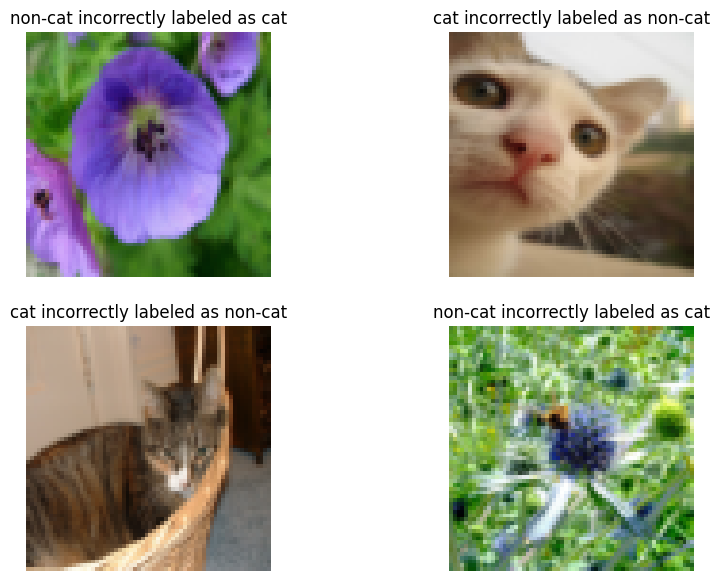

In [22]:
# pick 4 indices to show from the incorrect predictions
indices = [1, 3, 5, 7]

# create figure
fig = plt.figure(figsize = (10, 7))

# define # of rows / columns
rows = 2
cols = 2

subplot_index = 1
for ind in indices: 
    fig.add_subplot(rows, cols, subplot_index)
    subplot_index += 1
    plt.imshow(X_test[ind])
    plt.axis('off') 

    # craft the title string for each picture
    label_true_int = int(Y_test[ind][0])
    label_pred_int = int(Y_test_pred[ind][0])
    label_true_str = labels[label_true_int].decode('utf-8')
    label_pred_str = labels[label_pred_int].decode('utf-8')
    title = f'{label_true_str} incorrectly labeled as {label_pred_str}'
    plt.title(title)